# Imports

In [1]:
import random
import pandas as pd
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt

import gzip
import json

from collections import defaultdict
import heapq
from tqdm import tqdm

2025-12-01 02:51:05.207970: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 02:51:05.219156: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-01 02:51:05.264043: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-01 02:51:05.264999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 02:51:05.913002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Loader Functions

In [2]:
def readGz(path):
    # Open in text mode ('rt') with UTF-8 encoding for JSON lines
    path = "datasets/" + path
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for l in f:
            # Safely parse each line as JSON
            yield json.loads(l)

def load_to_dict(file_to_read):
    data = []
    try:
        for item in tqdm(readGz(file_to_read), desc=f"Loading {file_to_read}"):
            data.append(item)
    except EOFError as e:
        # Catching the specific EOFError indicating a corrupted file
        print(f"EOFError: Compressed file '{file_to_read}' ended prematurely. Error: {e}")
        print(f"This often indicates a corrupted or incomplete gzip file. Successfully loaded {len(data)} items before the error.")
    except Exception as e:
        # Catching other potential errors during decompression or JSON parsing
        print(f"An unexpected error occurred while reading '{file_to_read}': {e}")
        print(f"Successfully loaded {len(data)} items before the error.")
    return data

def save_likes(filename, data_dict):
    filename = "eval/"+filename
    with open(filename, "w") as fp:
        json.dump(data_dict, fp, indent=4)
    print("Saved to ", filename)

def load_user_likes(filename):
    """
    Load a user_likes JSON file back into a dict[user_id] = list of liked places.
    """
    filename = "eval/"+filename
    with open(filename, "r") as f:
        data = json.load(f)

    # Ensure values are lists, not sets or other types
    return {user_id: list(likes) for user_id, likes in data.items()}


# Exploratory Analysis

In [3]:
# Files we're checking the evaluation from
REVIEW_DATA_FNAME = "review-Oregon_10.json.gz"
METADATA_DATA_FNAME = "meta-Oregon.json.gz"

In [4]:
# load data
reviews = load_to_dict(REVIEW_DATA_FNAME)
metadata = load_to_dict(METADATA_DATA_FNAME)

review_df = pd.DataFrame(reviews)
meta_df = pd.DataFrame(metadata)

Loading review-Oregon_10.json.gz: 6270332it [01:32, 67979.73it/s] 
Loading meta-Oregon.json.gz: 93476it [00:04, 20355.73it/s]


In [5]:
print("REVIEWS STATS: ")

num_reviews = len(review_df)
num_users = review_df["user_id"].nunique()
num_items = review_df["gmap_id"].nunique()

# Rating distribution
rating_counts = review_df["rating"].value_counts().sort_index()

# Interactions per user stats
user_interaction_counts = review_df["user_id"].value_counts()
avg_reviews_per_user = user_interaction_counts.mean()
median_reviews_per_user = user_interaction_counts.median()

# Interactions per item stats
item_interaction_counts = review_df["gmap_id"].value_counts()
avg_reviews_per_item = item_interaction_counts.mean()
median_reviews_per_item = item_interaction_counts.median()

print(f"Total number of reviews: {num_reviews}")
print(f"Total unique users: {num_users}")
print(f"Total unique items: {num_items}\n")

print("Columns: ",list(review_df.columns),"\n")

print("Rating distribution:")
print(rating_counts, "\n")

print("User review count stats:")
print(f"  Avg reviews per user:    {avg_reviews_per_user:.3f}")
print(f"  Median reviews per user: {median_reviews_per_user}\n")

print("Item review count stats:")
print(f"  Avg reviews per item:    {avg_reviews_per_item:.3f}")
print(f"  Median reviews per item: {median_reviews_per_item}")

num_pos_interactions = (review_df["rating"] >= 4).sum()
print(f"\nNumber of interactions with rating ≥ 4: {num_pos_interactions}\n")

print("Top 10 Most Popular gmap_id (by number of ratings):\n")

item_stats = (
    review_df.groupby("gmap_id")
             .agg(
                 num_ratings=("rating", "count"),
                 avg_rating=("rating", "mean")
             )
             .sort_values("num_ratings", ascending=False)
             .head(10)
)

print(item_stats)
print()

REVIEWS STATS: 
Total number of reviews: 6270332
Total unique users: 204623
Total unique items: 47121

Columns:  ['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id'] 

Rating distribution:
rating
1     251454
2     205157
3     633110
4    1479821
5    3700790
Name: count, dtype: int64 

User review count stats:
  Avg reviews per user:    30.643
  Median reviews per user: 19.0

Item review count stats:
  Avg reviews per item:    133.069
  Median reviews per item: 43.0

Number of interactions with rating ≥ 4: 5180611

Top 10 Most Popular gmap_id (by number of ratings):

                                       num_ratings  avg_rating
gmap_id                                                       
0x549575786b8b269f:0xb3548313bd7fccfd         7937    4.294444
0x54950c57cd36d3cb:0x6f866d66264752ab         7838    4.350344
0x5495a40b739922e1:0x1386e3022fac1181         7432    4.363159
0x5495a0b4338cb23b:0xdf44bd5a7cbcbde4         6712    3.893176
0x54ea92b04ed31491:0xf497b

REVIEWS CHARTS: 


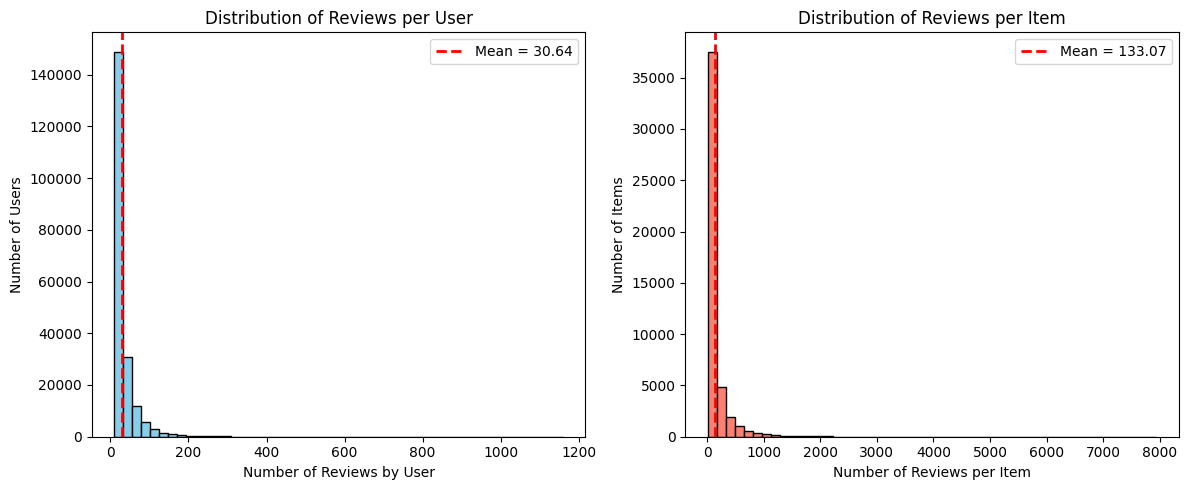

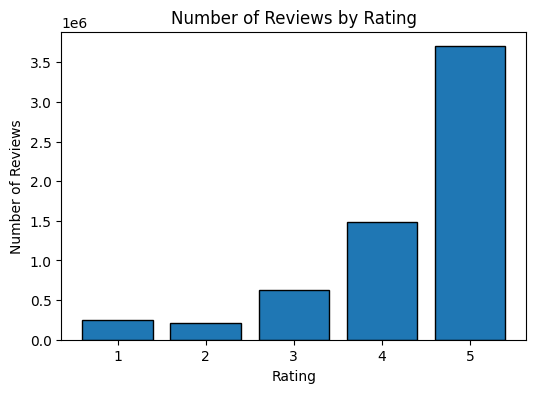

In [6]:
print("REVIEWS CHARTS: ")

# Histogram of reviews per user + item
plt.figure(figsize=(12,5))

# Reviews per user
plt.subplot(1,2,1)
plt.hist(user_interaction_counts, bins=50, color='skyblue', edgecolor='black')
plt.axvline(user_interaction_counts.mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean = {user_interaction_counts.mean():.2f}")
plt.title("Distribution of Reviews per User")
plt.xlabel("Number of Reviews by User")
plt.ylabel("Number of Users")
plt.legend()

# Reviews per item
plt.subplot(1,2,2)
plt.hist(item_interaction_counts, bins=50, color='salmon', edgecolor='black')
plt.axvline(item_interaction_counts.mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean = {item_interaction_counts.mean():.2f}")
plt.title("Distribution of Reviews per Item")
plt.xlabel("Number of Reviews per Item")
plt.ylabel("Number of Items")
plt.legend()

plt.tight_layout()

plt.savefig("user_item_dist.png")
plt.show()

rating_counts = review_df["rating"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(rating_counts.index.astype(str), rating_counts.values, edgecolor='black')

plt.title("Number of Reviews by Rating")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.savefig("reviews_by_rating.png")
plt.show()

# review_df["text_length"] = review_df["text"].fillna("").apply(len)

# print("TEXT LENGTH STATS:\n")
# print(review_df["text_length"].describe())

# plt.figure(figsize=(6,4))
# plt.hist(review_df["text_length"], bins=50, edgecolor="black")
# plt.title("Histogram: Review Text Length")
# plt.xlabel("Length (# characters)")
# plt.ylabel("Number of Reviews")
# plt.savefig("review_text_length.png")
# plt.show()

In [7]:
print("METADATA STATS: ")

print(f"Total number of places: {len(meta_df)}")

print("Columns in metadata:", list(meta_df.columns), "\n")

# Convert price symbols to numeric levels
price_levels = meta_df["price"].fillna("Unlisted").astype(str).apply(lambda x: 0 if x=="Unlisted" else len(x))
price_counts_by_length = price_levels.value_counts().sort_index()

# Map numeric levels to readable symbols
symbol_map = {0: "Unlisted", 1: "$", 2: "$$", 3: "$$$", 4: "$$$$"}
labels = [symbol_map.get(level, f"{level}-symbol") for level in price_counts_by_length.index]

# Escape $ symbols by prefixing with backslash
safe_labels = [label.replace("$", r"\$") for label in labels]

# Print counts
print("Price level counts (0 = Unlisted):")
for label, count in zip(labels, price_counts_by_length.values):
    print(f"{label}: {count}")

def parse_days_open(hours):
    days_open = [0]*7  # Monday=0 ... Sunday=6
    if isinstance(hours, list):
        for d in hours:
            day, time = d
            if str(time).lower() != "closed":
                if day == "Monday":
                    days_open[0] = 1
                elif day == "Tuesday":
                    days_open[1] = 1
                elif day == "Wednesday":
                    days_open[2] = 1
                elif day == "Thursday":
                    days_open[3] = 1
                elif day == "Friday":
                    days_open[4] = 1
                elif day == "Saturday":
                    days_open[5] = 1
                elif day == "Sunday":
                    days_open[6] = 1
    return sum(days_open)  # Total days open

# Apply to dataframe
meta_df["days_open"] = meta_df["hours"].apply(parse_days_open)

# Print stats
print("Days open per week (0 = unknown / all closed):")
print(meta_df["days_open"].value_counts().sort_index(), "\n")
print(meta_df["days_open"].describe())
print()


meta_df["desc_length"] = meta_df["description"].fillna("").apply(len)
print(meta_df["desc_length"].describe(), "\n")

print("Examples:")
print(f"Shortest description length: {meta_df['desc_length'].min()}")
print(f"Longest description length:  {meta_df['desc_length'].max()}\n")

METADATA STATS: 
Total number of places: 93476
Columns in metadata: ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url'] 

Price level counts (0 = Unlisted):
Unlisted: 78887
$: 7102
$$: 7051
$$$: 400
$$$$: 36
Days open per week (0 = unknown / all closed):
days_open
0    22426
1      947
2      509
3      884
4     2812
5    21041
6    12286
7    32571
Name: count, dtype: int64 

count    93476.000000
mean         4.522904
std          2.752176
min          0.000000
25%          1.000000
50%          5.000000
75%          7.000000
max          7.000000
Name: days_open, dtype: float64

count    93476.000000
mean        14.523418
std         33.842137
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        110.000000
Name: desc_length, dtype: float64 

Examples:
Shortest description length: 0
Longest description length:  110

METADATA PLOTS: 


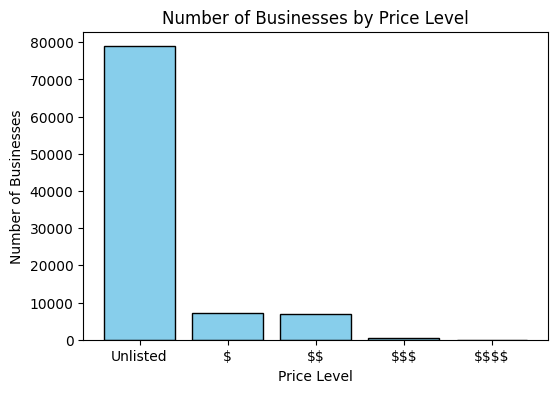

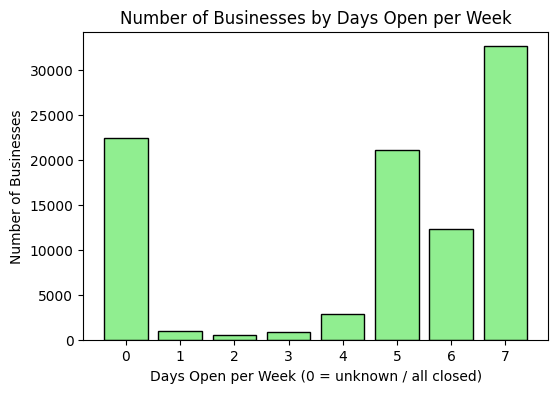

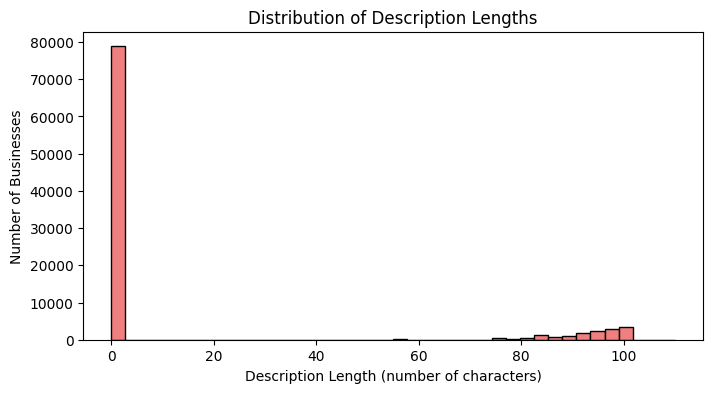

In [8]:
print("METADATA PLOTS: ")

# ---- BAR CHART ----
plt.figure(figsize=(6,4))
plt.bar(safe_labels, price_counts_by_length.values, color='skyblue', edgecolor='black')
plt.title("Number of Businesses by Price Level")
plt.xlabel("Price Level")
plt.ylabel("Number of Businesses")
plt.savefig("price_level.png")
plt.show()

# Bar chart
days_counts = meta_df["days_open"].value_counts().sort_index()
plt.figure(figsize=(6,4))
plt.bar(days_counts.index, days_counts.values, color='lightgreen', edgecolor='black')
plt.title("Number of Businesses by Days Open per Week")
plt.xlabel("Days Open per Week (0 = unknown / all closed)")
plt.ylabel("Number of Businesses")
plt.xticks(range(0,8))  # Show 0–7
plt.savefig("open_days.png")
plt.show()

# Histogram of description lengths
plt.figure(figsize=(8,4))
plt.hist(meta_df["desc_length"], bins=40, color='lightcoral', edgecolor='black')
plt.title("Distribution of Description Lengths")
plt.xlabel("Description Length (number of characters)")
plt.ylabel("Number of Businesses")
plt.savefig("desc_length.png")
plt.show()

# Pre-processing

## Universal Variables

In [9]:
TOP_K = 30
RANDOM_SEED = 42
POS_THRESHOLD = 4

RATIO_FOR_REVEALED = 0.8

FULL_LIKES_DATA_FNAME = "users_likes_full.json"
REVEALED_LIKES_DATA_FNAME = "users_revealed_likes.json"
HIDDEN_LIKES_DATA_FNAME = "users_hidden_likes.json"
HIDDEN_LIKES_BPR_DATA_FNAME = "users_hidden_likes_BPR.json"

ITER_UPDATE_REC_FNAME = "iterative_update_recommendation_per_user.json"
BPR_REC_FNAME = "bpr_recommendation_per_user.json"

BASELINE_REC_FNAME = "baseline_recommendation_per_user.json"

## The Pre-processing of the data

In [ ]:
# Loading the data
# reviews = load_to_dict(REVIEW_DATA_FNAME)[:100000]
# metadata = load_to_dict(METADATA_DATA_FNAME)
reviews = reviews[:100000]

In [ ]:
# Get each users' highly reviewed stores list
# users_likes[user_id] = [stores they rated >= 4]
users_likes = defaultdict(set)
dupe_review_count = 0
dupe_removed_count = 0

for review in reviews:
    user_id = review["user_id"]
    gmap_id = review["gmap_id"]
    rating = review["rating"]

    if gmap_id in users_likes[user_id]:
        dupe_review_count += 1
    
    # Use the most recent review, meaning if a user re-reviewed a place and they didn't like it, update our set
    if gmap_id in users_likes[user_id] and rating < POS_THRESHOLD:
        users_likes[user_id].remove(gmap_id)
        dupe_removed_count += 1

    if rating >= POS_THRESHOLD and (gmap_id not in users_likes[user_id]):
        users_likes[user_id].add(gmap_id)

print("Num dupes: ", dupe_review_count) 
print("Num dupes removed: ", dupe_removed_count) 

train_records = []
test_records = []

# Split off the users_likes to revealed and hidden
users_revealed_likes = defaultdict(list)
users_hidden_likes = defaultdict(list)
users_total_likes = defaultdict(list)

random.seed(RANDOM_SEED)
for user_id, liked_places in users_likes.items():
    # For now let's say 8:2 ratio for revealed vs hidden
    # Shuffle before splitting

    liked_list = list(liked_places)
    num_likes = len(liked_list)
    
    random.shuffle(liked_list)

    # ensures at least 1 review is hidden
    min_hidden_count = 1
    split_point = max(min_hidden_count, int(RATIO_FOR_REVEALED * num_likes))

    revealed = liked_list[split_point:]
    hidden = liked_list[:split_point]
    
    if len(hidden) >= min_hidden_count:
        users_revealed_likes[user_id] = revealed
        users_hidden_likes[user_id] = hidden
        users_total_likes[user_id] = liked_list

# Save user likes: revealed, hidden, and full
save_likes(FULL_LIKES_DATA_FNAME, users_total_likes)
save_likes(REVEALED_LIKES_DATA_FNAME, users_revealed_likes)
save_likes(HIDDEN_LIKES_DATA_FNAME, users_hidden_likes)

# Models

## Iterative Update (HW3) Model

In [ ]:
# The functions we'll use for to update in the iterations

def getGlobalAverage(trainRatings):
    # Return the average rating in the training set
    res = numpy.average(trainRatings)

    return res

def alphaUpdate(ratingsTrain, alpha, betaU, betaLoc, lamb):
    # Update equation for alpha
    newAlpha = 0

    # From slide 83 of the recommendation slide
    # alpha = sum_{u,i in train} (R_u,i - (betaU + betaLoc)) / Ntrain
    Ntrain = len(ratingsTrain)

    for u, loc, rating in ratingsTrain:
        # u, loc, rating = r["user_id"], r["gmap_id"], r["rating"]

        newAlpha += rating - (betaU[u] + betaLoc[loc])
    
    newAlpha /= Ntrain

    return newAlpha

def betaUUpdate(ratingsPerUser, alpha, betaU, betaLoc, lamb):
    # Update equation for betaU
    newBetaU = {}

    # From slide 83 of the recommendation slide
    # betaU = sum_{i in I_u} (R_u,i - (alpha + betaLoc)) / (lamb + |I_u|)
    
    # Structure is ratingsPerUser[user] = [(location, rating)]
    # betaU[user] = how much does this user tend to rate things above mean

    for u in ratingsPerUser:
        curr = 0
        
        for i, r in ratingsPerUser[u]:
            curr += r - (alpha + betaLoc[i])
    
        curr /= (lamb + len(ratingsPerUser[u]))

        newBetaU[u] = curr

    return newBetaU

def betaLocUpdate(ratingsPerLocation, alpha, betaU, betaLoc, lamb):
    # Update equation for betaLoc
    newBetaLoc = {}

    # From slide 83 of the recommendation slide
    # betaU = sum_{u in U_i} (R_u,i - (alpha + betaU)) / (lamb + |U_i|)

    # ratingsPerLocation[location] = [(user, rating)]

    for i in ratingsPerLocation:
        curr = 0

        for u, r in ratingsPerLocation[i]:
            curr += r - (alpha + betaU[u])
        
        curr /= (lamb + len(ratingsPerLocation[i]))

        newBetaLoc[i] = curr

    return newBetaLoc

In [ ]:
# The model we're using
def iterativeUpdateModel(ratingsTrain, ratingsPerUser, ratingsPerLocation, alpha, betaU, betaLoc):
    # Improve upon your model from the previous question (e.g. by running multiple iterations)

    # Running multiple iterations
    lamb = 0.5
    for i in range(100):
        alpha = alphaUpdate(ratingsTrain, alpha, betaU, betaLoc, lamb)
        betaU = betaUUpdate(ratingsPerUser, alpha, betaU, betaLoc, lamb)
        betaLoc = betaLocUpdate(ratingsPerLocation, alpha, betaU, betaLoc, lamb)

    return alpha, betaU, betaLoc

In [ ]:
# Extra pre-processing for this specific model: get all users and locations from the test set
# Also, get all the reviews that are revealed / negative (which will be used to train)

test_users_IUM = set()
test_locations_IUM = set()

# of (user_id, gmap_id, rating)
test_revealed_and_negative_reviews = set()

for review in reviews:
    user = review["user_id"]
    test_users_IUM.add(user)

    loc = review["gmap_id"]
    test_locations_IUM.add(loc)

    rating = review["rating"]

    if loc in users_revealed_likes[user] or rating < 4:
        test_revealed_and_negative_reviews.add((user, loc, rating))

test_users_IUM = list(test_users_IUM)
test_locations_IUM = list(test_locations_IUM)

In [ ]:
# Use the train set to figure out the generally ideal alpha, betaU, betaLoc of the model in this kind of task
ratingsTrain = test_revealed_and_negative_reviews
ratingsPerUser = defaultdict(list)
ratingsPerLocation = defaultdict(list)
for u, loc, r in ratingsTrain:
    ratingsPerUser[u].append((loc,r))
    ratingsPerLocation[loc].append((u,r))

trainRatings = [r for _, _, r in ratingsTrain]

betaU = {}
betaLoc = {}
for u in ratingsPerUser:
    betaU[u] = 0

for loc in ratingsPerLocation:
    betaLoc[loc] = 0

alpha = getGlobalAverage(trainRatings) # Could initialize anywhere, this is a guess

alpha, betaU, betaLoc = iterativeUpdateModel(ratingsTrain, ratingsPerUser, ratingsPerLocation, alpha, betaU, betaLoc)

In [ ]:
# Go through each user and location, get the recommendations
recommendation = {}

for user_id in tqdm(test_users_IUM):
    # min-heap storing (score, gmap_id)
    heap = []

    bu = betaU.get(user_id, 0)

    revealed = users_revealed_likes[user_id]

    for gmap_id in test_locations_IUM:

        if gmap_id in revealed:
            continue

        bi = betaLoc.get(gmap_id, 0)
        score = alpha + bu + bi

        if len(heap) < TOP_K:
            # just push until full
            heapq.heappush(heap, (score, gmap_id))
        else:
            # if better than the smallest in heap → replace the smallest
            if score > heap[0][0]:
                heapq.heapreplace(heap, (score, gmap_id))

    # extract best K sorted from highest to lowest
    heap.sort(reverse=True)
    recommendation[user_id] = [gmap_id for score, gmap_id in heap]

# Export to json
save_likes(ITER_UPDATE_REC_FNAME, recommendation)

## Bayesian Personalized Ranking (BPR) Model
Note: Codes referenced from the Professor's page Chapter 5

In [ ]:
# BPR-specific variables
MIN_INTERACTIONS_PER_USER = 1
MAX_USERS = 100000
MAX_ITEMS = 100000

LATENT_DIM = 64
LEARNING_RATE = 0.01
REG_LAMBDA = 1e-5
NSAMPLES_PER_BATCH = 50000
N_TRAIN_STEPS = 1000

In [ ]:
# Extra pre-processing for this model
random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

df = pd.DataFrame(reviews)


df_pos = df[df["rating"] >= POS_THRESHOLD].copy()

user_counts = df_pos["user_id"].value_counts()
eligible_users = user_counts[user_counts >= MIN_INTERACTIONS_PER_USER].index

df_pos = df_pos[df_pos["user_id"].isin(eligible_users)].reset_index(drop=True)


# Limiting the unique users and items. This is done for the sake of time.
# For the record, we tried running this without the limitation and the score we got was negligibly similar to the one with this limitation.
unique_users = df_pos["user_id"].unique()
if MAX_USERS is not None:
    unique_users = unique_users[:MAX_USERS]

df_pos = df_pos[df_pos["user_id"].isin(unique_users)]

unique_items = df_pos["gmap_id"].unique()
if MAX_ITEMS is not None:
    unique_items = unique_items[:MAX_ITEMS]

df_pos = df_pos[df_pos["gmap_id"].isin(unique_items)].reset_index(drop=True)

user_id_to_idx = {u: idx for idx, u in enumerate(unique_users)}
item_id_to_idx = {i: idx for idx, i in enumerate(unique_items)}

df_pos["user_idx"] = df_pos["user_id"].map(user_id_to_idx)
df_pos["item_idx"] = df_pos["gmap_id"].map(item_id_to_idx)

num_users = len(user_id_to_idx)
num_items = len(item_id_to_idx)


# Shuffle rows (if no timestamp, just randomize)
if "time" in df_pos.columns:
    df_pos = df_pos.sort_values(["user_idx", "time"])
else:
    df_pos = df_pos.sample(frac=1.0, random_state=RANDOM_SEED)

train_rows = []
test_rows = []

# Split each user's interactions 80:20
for user_id, group in df_pos.groupby("user_id"):
    idx_list = group.index.tolist()
    random.shuffle(idx_list)
    
    split_point = max(1, int(RATIO_FOR_REVEALED * len(idx_list)))  # ensure at least 1 row in train
    train_rows.extend(idx_list[:split_point])
    test_rows.extend(idx_list[split_point:])

train_df = df_pos.loc[train_rows].reset_index(drop=True)
test_df = df_pos.loc[test_rows].reset_index(drop=True)

# Get a translation dictionary so we know the user and location id we're referring to by their idx after the fitting
idx_to_user_id = {idx: u for u, idx in user_id_to_idx.items()}
idx_to_item_id = {idx: i for i, idx in item_id_to_idx.items()}


interactions_train = list(
    zip(
        train_df["user_idx"].astype(int).tolist(),
        train_df["item_idx"].astype(int).tolist(),
        train_df["rating"].tolist()
    )
)

items_per_user_train = defaultdict(set)
for u, i, r in interactions_train:
    items_per_user_train[u].add(i)

all_items = list(range(num_items))

In [ ]:
# The model we're using
class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super().__init__()
        self.lamb = lamb

        # Global item bias
        self.betaI = self.add_weight(
            name="betaI",
            shape=(num_items,),
            initializer=tf.random_normal_initializer(stddev=0.001),
            trainable=True,
        )

        # User latent factors
        self.gammaU = self.add_weight(
            name="gammaU",
            shape=(num_users, K),
            initializer=tf.random_normal_initializer(stddev=0.001),
            trainable=True,
        )

        # Item latent factors
        self.gammaI = self.add_weight(
            name="gammaI",
            shape=(num_items, K),
            initializer=tf.random_normal_initializer(stddev=0.001),
            trainable=True,
        )

    def score(self, sampleU, sampleI):
        # sampleU, sampleI are index tensors
        u = tf.cast(sampleU, tf.int32)
        i = tf.cast(sampleI, tf.int32)

        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)

        x_ui = beta_i + tf.reduce_sum(gamma_u * gamma_i, axis=1)
        return x_ui

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        # BPR loss: -log σ(x_ui - x_uj)
        loss = -tf.reduce_mean(tf.math.log_sigmoid(x_ui - x_uj))
        return loss

    def reg(self):
        return self.lamb * (
            tf.nn.l2_loss(self.betaI)
            + tf.nn.l2_loss(self.gammaU)
            + tf.nn.l2_loss(self.gammaI)
        )

In [ ]:
# Training the model
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
modelBPR = BPRbatch(LATENT_DIM, REG_LAMBDA)

def trainingStepBPR(model, interactions, items_per_user, items, Nsamples):
    sampleU, sampleI, sampleJ = [], [], []

    for _ in range(Nsamples):
        u, i, r = random.choice(interactions)
        j = random.choice(items)
        while j in items_per_user[u]:
            j = random.choice(items)

        sampleU.append(u)
        sampleI.append(i)
        sampleJ.append(j)

    # Convert lists → tensors
    sampleU_tf = tf.convert_to_tensor(sampleU, dtype=tf.int32)
    sampleI_tf = tf.convert_to_tensor(sampleI, dtype=tf.int32)
    sampleJ_tf = tf.convert_to_tensor(sampleJ, dtype=tf.int32)

    with tf.GradientTape() as tape:
        loss = model(sampleU_tf, sampleI_tf, sampleJ_tf)
        loss += model.reg()

    grads = tape.gradient(loss, model.trainable_variables)

    # Pair gradients with variables, skipping any None grads just in case
    grads_and_vars = [
        (g, v) for g, v in zip(grads, model.trainable_variables) if g is not None
    ]

    if grads_and_vars:
        optimizer.apply_gradients(grads_and_vars)
    else:
        print("Warning: no gradients to apply this step.")

    return float(loss.numpy())

# Run the training
test_loss = trainingStepBPR(
    modelBPR,
    interactions_train,
    items_per_user_train,
    all_items,
    Nsamples=NSAMPLES_PER_BATCH  # mini testing
)

print(f"One mini-batch objective: {test_loss:.4f}")

for step in range(N_TRAIN_STEPS):
    obj = trainingStepBPR(
        modelBPR,
        interactions_train,
        items_per_user_train,
        all_items,
        NSAMPLES_PER_BATCH,
    )
    if (step + 1) % 5 == 0:
        print(f"Step {step + 1}, objective = {obj:.4f}")

In [ ]:
# Getting the recommendation

test_items_per_user = defaultdict(list)
for _, row in test_df.iterrows():
    u = int(row["user_idx"])
    i = int(row["item_idx"])
    test_items_per_user[u].append(i)

def get_top_k_recommendations(model, train_items_per_user, test_items_per_user, items, k, idx_to_user_id, idx_to_item_id):
    """
    Returns: dict of user_id -> list of top-k gmap_ids, excluding training items.
    """
    recs = {}
    users = list(test_items_per_user.keys())
    all_items_array = numpy.array(items, dtype=numpy.int32)

    for idx, u in enumerate(users):
        user_id = idx_to_user_id[u]

        train_items = train_items_per_user[u]

        # Candidate items = all items not already interacted with
        candidate_mask = ~numpy.isin(all_items_array, list(train_items))
        candidate_items = all_items_array[candidate_mask]

        if len(candidate_items) == 0:
            recs[user_id] = []
            continue

        # Score all candidate items
        u_list = numpy.full(len(candidate_items), u, dtype=numpy.int32)
        scores = model.score(u_list, candidate_items).numpy()

        # Sort scores and get top-k
        top_idx = numpy.argsort(-scores)[:k]  # sorted descending
        top_item_indices_sorted = candidate_items[top_idx]

        # Map indices back to gmap_ids
        top_item_ids = [idx_to_item_id[i] for i in top_item_indices_sorted]

        recs[user_id] = top_item_ids

    return recs

# Running the function and getting the recommendations
recommendation = get_top_k_recommendations(
    modelBPR,
    items_per_user_train,
    test_items_per_user,
    all_items,
    TOP_K,
    idx_to_user_id,
    idx_to_item_id
)

In [ ]:
# Exporting to json

# Save the recommendations to a file so it can be used in the evaluation function
save_likes(BPR_REC_FNAME, recommendation)

# Also save the hidden likes
users_hidden_likes = defaultdict(list)

for _, row in test_df.iterrows():
    user_id = idx_to_user_id[row["user_idx"]]
    item_id = idx_to_item_id[row["item_idx"]]
    users_hidden_likes[user_id].append(item_id)

users_hidden_likes = dict(users_hidden_likes)

# Saving the hidden likes specific for this
# This is because of the 100000 limiting of users and items as done above
save_likes(HIDDEN_LIKES_BPR_DATA_FNAME, users_hidden_likes)

# Unused Models

## Linear Regression

In [ ]:
# # Feature vector
# def feature(datum):
#     feat = [1]

#     # The features that make sense to see:
#     # price, latitude/longitude, description length, num_of_reviews

#     feat.append(len(datum["price"]) if datum["price"] else 0)
#     # feat.append(datum["latitude"])
#     # feat.append(datum["longitude"])

#     feat.append(len(datum["description"]) if datum["description"] else 0)
#     feat.append(datum["num_of_reviews"])

#     # Days open
#     days_open = [0] * 7

#     if datum["hours"]:
#         for d in datum["hours"]:
#             if d[0] == "Monday" and str.lower(d[1]) != "closed":
#                 days_open[0] = 1
#             if d[0] == "Tuesday" and str.lower(d[1]) != "closed":
#                 days_open[1] = 1
#             if d[0] == "Wednesday" and str.lower(d[1]) != "closed":
#                 days_open[2] = 1
#             if d[0] == "Thursday" and str.lower(d[1]) != "closed":
#                 days_open[3] = 1
#             if d[0] == "Friday" and str.lower(d[1]) != "closed":
#                 days_open[4] = 1
#             if d[0] == "Saturday" and str.lower(d[1]) != "closed":
#                 days_open[5] = 1
#             if d[0] == "Sunday" and str.lower(d[1]) != "closed":
#                 days_open[6] = 1

#     feat += days_open

#     # Categories
#     # cat_one_hot = [0] * len(list(cats))
    
#     # if datum["category"]:
#     #     for c in datum["category"]:
#     #         cat_one_hot[cats[c]] = 1

#     # feat += cat_one_hot

#     # Planning
#     # plannings_one_hot = [0] * len(list(plannings))
#     # if datum["MISC"] and "Planning" in datum["MISC"] and datum["MISC"]["Planning"]:
#     #     for p in datum["MISC"]["Planning"]:
#     #         plannings_one_hot[plannings[p]] = 1
    
#     # feat += plannings_one_hot

#     # Payment
#     # payments_one_hot = [0] * len(list(payments))
#     # if datum["MISC"] and "Payments" in datum["MISC"] and datum["MISC"]["Payments"]:
#     #     for p in datum["MISC"]["Payments"]:
#     #         payments_one_hot[payments[p]] = 1
    
#     # feat += payments_one_hot

#     return feat

In [ ]:
# # Implement and predict

# y = numpy.array([d["avg_rating"] for d in train_metadata])

# x = numpy.array([feature(d) for d in train_metadata])

# # Setting up the logistic regression using sklearn library (class weight is balanced)
# regr = linear_model.LinearRegression()

# # Train the model using feature = x, label = y
# regr.fit(x, y)

# # Now predict if we feed the model another feature (x)
# x_test = numpy.array([feature(d) for d in metadata])

# y_train_prediction = regr.predict(x_test)

# loc_and_pred = []

# for i in range(len(x_test)):
#     loc_and_pred.append((y_train_prediction[i], metadata[i]["gmap_id"]))

# loc_and_pred.sort(reverse=True)

# popularity_list_id = [b for a, b in loc_and_pred]

# # Building the dictionary to feed to the evaluation function (same as baseline)
# # recommendation[user_id] = [top k items the model recommend]
# recommendation = {}

# # Get each user that has reviewed
# for review in reviews:
#     user_id = review["user_id"]

#     # Recommend the top number of hidden reviews for each user
#     if user_id not in recommendation:
#         # Filter the popularity list so that the users' revealed likes isn't included here
#         filtered_popularity_list = []

#         for name in popularity_list_id:
#             if name not in users_revealed_likes[user_id]:
#                 filtered_popularity_list.append(name)

#             if len(filtered_popularity_list) == k:
#                 break

#         recommendation[user_id] = filtered_popularity_list[:k]

# loader.save_likes("linear_regression_recommendation_per_user.json", recommendation)

# Evaluation and Baseline

## Baseline Model

In [ ]:
# Because the baseline doesn't need any training, we build it off of the entire set
# We’ll use a standard baseline for ranking latent factor model, which is by always recommending the top most popular places in the testing dataset
# “Popular” means aggregation of features from each places’ metadata; number of reviews * average rating per store

# Preprocessing the data; get the number of reviews per store in the metadata
locations_review_count = defaultdict(int)
locations_avg_rating = defaultdict(int)

# First get the count of all the reviews for each location
for review in reviews:
    locations_review_count[review["gmap_id"]] += 1

# Get the average rating listed in the metadata
for metadata in metadata:
    locations_avg_rating[metadata["gmap_id"]] = metadata["avg_rating"]

# Then multiply the two collected data and fill in the locations_popularity[gmap_id] = number of reviews * average rating
locations_popularity = defaultdict(int)

for gmap_id in locations_review_count:
    locations_popularity[gmap_id] = locations_review_count[gmap_id] * locations_avg_rating[gmap_id]


# Getting the resulting "most popular" list that can be used for the baseline
# Turn the locations_popularity dictionary to list of tuples that we can sort
popularity_list = [(pop, gmap_id) for gmap_id, pop in locations_popularity.items()]

# Sort in reverse order so the most popular place is at the top
popularity_list.sort(reverse=True)

# And then the gmap_id only list
popularity_list_id = [gmap_id for _, gmap_id in popularity_list]


# Building the dictionary to feed to the evaluation function
# recommendation[user_id] = [top k items the model recommend]
recommendation = {}

# Get each user that has reviewed
for review in reviews:
    user_id = review["user_id"]

    # Recommend the top number of hidden reviews for each user
    if user_id not in recommendation:
        # Filter the popularity list so that the users' revealed likes isn't included here
        filtered_popularity_list = []

        for name in popularity_list_id:
            if name not in users_revealed_likes[user_id]:
                filtered_popularity_list.append(name)

            if len(filtered_popularity_list) == TOP_K:
                break

        recommendation[user_id] = filtered_popularity_list[:TOP_K]

# Export to json
save_likes(BASELINE_REC_FNAME, recommendation)

## Evaluation

In [ ]:
def evalFunc(recs_fname, hidden_fname):
    recs = load_user_likes(recs_fname)
    hidden = load_user_likes(hidden_fname)

    hit_scores = {}  
    high_hit_scores = {}  

    for user_id, hidden_items in hidden.items():
        recommended_items = recs[user_id]

        # count how many hidden items appear in recommendations
        hits = sum(1 for item in hidden_items if item in recommended_items)

        # divide by number of hidden items
        #hit_rate = hits / len(hidden_items)
        
        hit_for_this_user = 1 if hits > 0 else 0
        
        hit_scores[user_id] = hit_for_this_user
        if len(hidden_items) < 2:
            high_hit_scores[user_id] = hit_for_this_user

    # average performance across all users
    overall_score = sum(hit_scores.values()) / len(hit_scores)

    print("Overall Hitrate@k score: ",overall_score)

    max_user = max(hit_scores, key=hit_scores.get)
    max_score = hit_scores[max_user]

    print("Highest score: ",max_score)

    # score when only considering high number of reviews
    overall_high_score = sum(high_hit_scores.values()) / len(high_hit_scores)

    print("Overall high hit score: ", overall_high_score)

In [ ]:
# Running the evaluations

print("Evaluation for Iterative Update Model")
evalFunc(ITER_UPDATE_REC_FNAME, HIDDEN_LIKES_DATA_FNAME)

print("Evaluation for BPR Model")
evalFunc(BPR_REC_FNAME, HIDDEN_LIKES_BPR_DATA_FNAME)

print("Evaluation for Baseline Model")
evalFunc(BASELINE_REC_FNAME, HIDDEN_LIKES_DATA_FNAME)